In [1]:
# ----------------------------------------------
# STEP 0: Initial Setup and Install Dependencies (UPDATED)
# ----------------------------------------------
# We are replacing 'pytorch-grad-cam' with 'grad-cam'
!pip install -q torchinfo scikit-learn grad-cam kagglehub

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from torchinfo import summary
import cv2
import kagglehub # Import for data download

# --- XAI Imports ---
# NOTE: If 'grad-cam' installed, these imports should still work, as the library is often installed under this namespace.
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# --- Data Download using kagglehub ---
try:
    path = kagglehub.dataset_download("navoneel/brain-mri-images-for-brain-tumor-detection")
    # kagglehub returns the path to the extracted dataset directory
    DATA_PATH = os.path.join(path, "brain_tumor_dataset")
    print("Path to dataset files:", DATA_PATH)
except Exception as e:
    print(f"Kagglehub download failed. Ensure API key is set. Error: {e}")
    # Fallback/Placeholder path in case of failure (Adjust this if needed)
    DATA_PATH = "/content/brain_tumor_dataset"


# Set device and constants
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")
NUM_CLASSES = 2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 43.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Using Colab cache for faster access to the 'brain-mri-images-for-brain-tumor-detection' dataset.
Path to dataset files: /kaggle/input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset
Using device: cuda:0


In [1]:
# ----------------------------------------------
# STEP 0: Initial Setup and Install Dependencies
# ----------------------------------------------
!pip install -q torchinfo scikit-learn grad-cam kagglehub
!pip install -q lime

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from torchinfo import summary
import cv2
import kagglehub

# --- XAI Imports ---
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# --- Data Download using kagglehub (NEW DATASET) ---
try:
    # Download the new multi-class dataset
    path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
    # The new dataset structure is often 'Training' and 'Testing' folders
    # We will point to the parent directory to let ImageFolder scan both
    DATA_PATH = path
    print("Path to dataset files:", DATA_PATH)
except Exception as e:
    print(f"Kagglehub download failed. Ensure API key is set. Error: {e}")
    DATA_PATH = "/content/brain_tumor_dataset" # Fallback


# Set device and constants
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")
NUM_CLASSES = 4 # Updated for glioma, meningioma, no tumor, pituitary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 62.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Using Colab cache for faster access to the 'brain-tumor-mri-dataset' dataset.
Path to dataset files: /kaggle/input/brain-tumor-mri-dataset
Using device: cuda:0


In [2]:
# ----------------------------------------------
# STEP 1: Data Preparation and Preprocessing (REVISED)
# ----------------------------------------------

# ResNet requires 224x224 input. Using ImageNet mean/std for pre-trained model.
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Define transformations
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

# Load the TRAINING subset of the data (assuming structure: DATA_PATH/Training/Class_Name/*.jpg)
train_full_dataset = datasets.ImageFolder(
    root=os.path.join(DATA_PATH, 'Training'),
    transform=data_transforms
)
# Load the TESTING subset of the data
test_full_dataset = datasets.ImageFolder(
    root=os.path.join(DATA_PATH, 'Testing'),
    transform=data_transforms
)

# Split the Training set further into Training and Validation for model tuning
train_size = len(train_full_dataset)
val_size = int(0.15 * train_size)
train_size = train_size - val_size

train_dataset, val_dataset = random_split(
    train_full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42)
)

# Use the Testing set as the final test set
test_dataset = test_full_dataset


# Create DataLoaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Total Training Images: {len(train_full_dataset)}")
print(f"Train/Validation/Test Split: {len(train_dataset)}/{len(val_dataset)}/{len(test_dataset)}")
CLASS_NAMES = train_full_dataset.classes
print(f"Class names: {CLASS_NAMES}")

Total Training Images: 5712
Train/Validation/Test Split: 4856/856/1311
Class names: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [3]:
# ----------------------------------------------
# STEP 2: Model Definition and Transfer Learning
# ----------------------------------------------

def build_resnet_model(num_classes):
    # Load pre-trained ResNet18
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

    # 1. Freeze initial layers
    for param in model.parameters():
        param.requires_grad = False

    # 2. UNFREEZE THE LAST CONVOLUTIONAL BLOCK (layer4) for Grad-CAM/training
    for param in model.layer4.parameters():
        param.requires_grad = True

    # 3. Replace and unfreeze the final fully connected layer
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    model.fc.requires_grad_(True)

    print("\n--- Model Summary ---")
    print(summary(model, input_size=(BATCH_SIZE, 3, 224, 224), device=DEVICE, verbose=0))

    return model.to(DEVICE)

In [4]:
# ----------------------------------------------
# STEP 3: Training and Evaluation Loop
# ----------------------------------------------

NUM_EPOCHS = 10
LEARNING_RATE = 0.001
model = build_resnet_model(NUM_CLASSES)
criterion = nn.CrossEntropyLoss()
# Only optimize parameters that are not frozen (i.e., the new final layer and layer4)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        # Training Phase (omitted details for brevity)
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)

        # Validation Phase (omitted details for brevity)
        model.eval()
        val_loss = 0.0
        corrects = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                corrects += torch.sum(preds == labels.data)
                total += labels.size(0)

        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = corrects.double() / total

        print(f'Epoch {epoch+1}/{num_epochs}: Train Loss: {epoch_loss:.4f} | Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.4f}')

        if epoch_val_acc > best_acc:
            best_acc = epoch_val_acc
            torch.save(model.state_dict(), 'best_model_weights.pth')
            print("--- Saved new best model weights ---")

    print(f'Training complete. Best validation accuracy: {best_acc:.4f}')
    model.load_state_dict(torch.load('best_model_weights.pth'))
    return model

# Start Training
trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 188MB/s]



--- Model Summary ---
Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 4]                   --
├─Conv2d: 1-1                            [32, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        (128)
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 64, 56, 56]          --
│    └─BasicBlock: 2-1                   [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          (36,864)
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          (36,864)
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-6               

In [5]:
# ----------------------------------------------
# STEP 4: Model Evaluation and Metrics
# ----------------------------------------------

def evaluate_model(model, test_loader, class_names):
    model.eval()
    y_true = []
    y_pred = []
    y_scores = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)

            # Predictions
            _, preds = torch.max(outputs, 1)

            # Probabilities for all 4 classes
            probs = torch.softmax(outputs, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_scores.extend(probs.cpu().numpy())

    # Classification Report
    print("\n--- Final Test Set Evaluation ---")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("\n--- Confusion Matrix ---")
    print(cm)

    # ROC-AUC Score (Multi-class: OVR (One vs Rest) with macro averaging)
    try:
        roc_auc = roc_auc_score(y_true, y_scores, multi_class='ovr', average='macro')
        print(f"\n--- ROC-AUC Score (Macro): {roc_auc:.4f} ---")
    except ValueError:
        print("\n--- ROC-AUC Score: Cannot be computed due to insufficient samples per class. ---")


# Evaluate the fully trained model
evaluate_model(trained_model, test_loader, CLASS_NAMES)


--- Final Test Set Evaluation ---
              precision    recall  f1-score   support

      glioma       0.97      0.98      0.98       300
  meningioma       0.98      0.95      0.97       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.99      0.99      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311


--- Confusion Matrix ---
[[295   5   0   0]
 [  8 292   2   4]
 [  0   0 405   0]
 [  0   2   0 298]]

--- ROC-AUC Score (Macro): 0.9990 ---



--- Model Summary ---
Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 4]                   --
├─Conv2d: 1-1                            [32, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        (128)
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 64, 56, 56]          --
│    └─BasicBlock: 2-1                   [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          (36,864)
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          (36,864)
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-6               

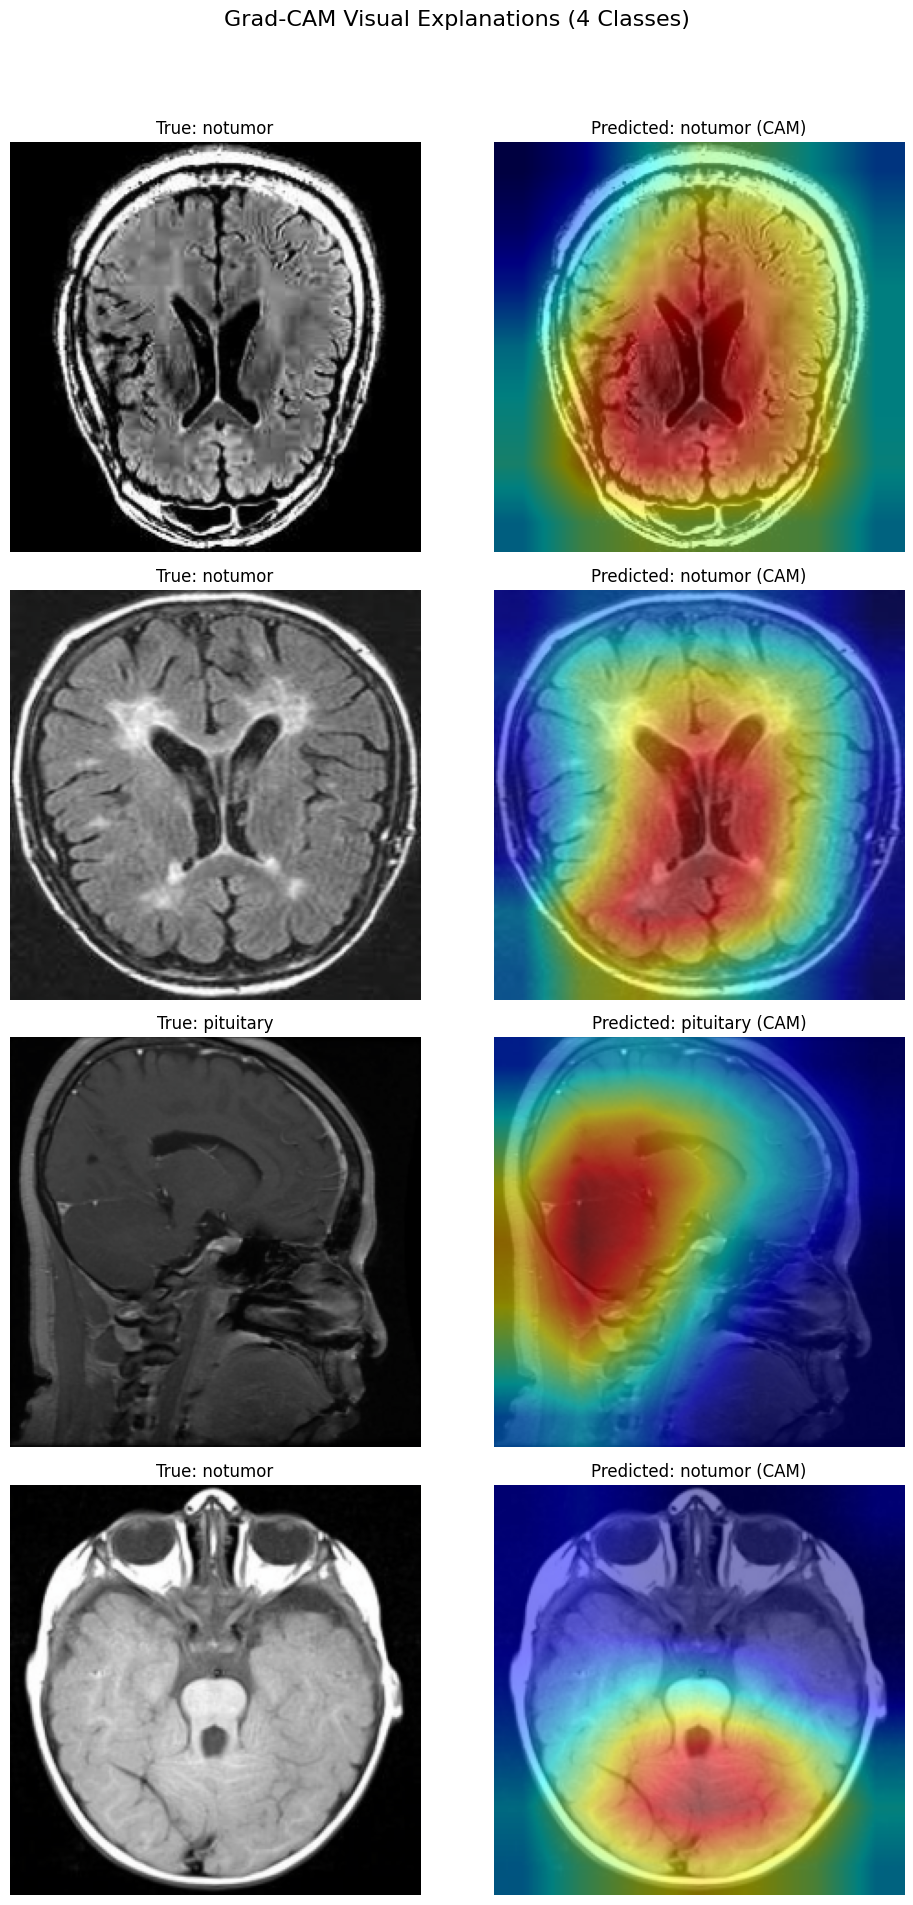

In [6]:
# ----------------------------------------------
# STEP 6: XAI Implementation (Grad-CAM)
# ----------------------------------------------

# Rebuild the model and load the best weights
final_model = build_resnet_model(NUM_CLASSES)
final_model.load_state_dict(torch.load('best_model_weights.pth'))
final_model.eval()

# The target layer for ResNet18
target_layers = [final_model.layer4[-1]]

# Create a Grad-CAM object (Fixed: removed use_cuda)
cam = GradCAM(model=final_model, target_layers=target_layers)

def visualize_grad_cam(model, dataset, cam_algorithm, num_samples=4):
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 5))
    fig.suptitle("Grad-CAM Visual Explanations (4 Classes)", fontsize=16)

    # Sample images from the test set
    indices = np.random.choice(len(dataset), num_samples, replace=False)

    for i, idx in enumerate(indices):
        original_img_tensor, true_label = dataset[idx]
        input_tensor = original_img_tensor.unsqueeze(0).to(DEVICE)

        output = model(input_tensor)
        predicted_label = torch.argmax(output).item()

        # Target for Grad-CAM is the predicted class (to explain *why* it predicted that)
        targets = [ClassifierOutputTarget(predicted_label)]

        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
        grayscale_cam = grayscale_cam[0, :]

        # De-normalize and prepare image for visualization
        rgb_img = original_img_tensor.permute(1, 2, 0).cpu().numpy()
        rgb_img = (rgb_img * np.array(IMAGENET_STD)) + np.array(IMAGENET_MEAN)
        rgb_img = np.clip(rgb_img, 0, 1)

        # Overlay the heatmap
        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

        # Plot original image
        axes[i, 0].imshow(rgb_img)
        axes[i, 0].set_title(f"True: {CLASS_NAMES[true_label]}")
        axes[i, 0].axis('off')

        # Plot CAM visualization
        axes[i, 1].imshow(visualization)
        axes[i, 1].set_title(f"Predicted: {CLASS_NAMES[predicted_label]} (CAM)")
        axes[i, 1].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Run the visualization on the test set
visualize_grad_cam(final_model, test_dataset, cam)

In [9]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
from torchvision.transforms import ToPILImage

# 1. Initialize LIME Image Explainer
explainer = lime_image.LimeImageExplainer()

def visualize_lime(model, dataset, num_samples=20):
    model.eval()
    fig, axes = plt.subplots(num_samples, 2, figsize=(12, num_samples * 6))
    fig.suptitle("LIME: Local Interpretable Model-agnostic Explanations", fontsize=16)

    # Helper for PIL conversion
    pil_transform = ToPILImage()

    # Define the prediction function LIME needs
    def batch_predict(images):
        model.eval()
        batch_tensors = []
        for img in images:
            # Convert numpy array (0-1 float) to 0-255 uint8 for PIL
            img_uint8 = (img * 255).astype(np.uint8)
            # Convert to PIL Image
            pil_img = pil_transform(img_uint8)
            # Apply your project's data_transforms (Resize, Normalize, etc.)
            t_img = data_transforms(pil_img)
            batch_tensors.append(t_img)

        # Stack into a single batch [B, C, H, W]
        batch = torch.stack(batch_tensors).to(DEVICE)

        with torch.no_grad():
            logits = model(batch)
            probs = torch.softmax(logits, dim=1)
        return probs.detach().cpu().numpy()

    # Sample images from the test set
    indices = np.random.choice(len(dataset), num_samples, replace=False)

    for i, idx in enumerate(indices):
        img_tensor, true_label = dataset[idx]

        # Convert tensor to numpy for LIME (H, W, C) and de-normalize for the explainer
        img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
        img_np = (img_np * np.array(IMAGENET_STD)) + np.array(IMAGENET_MEAN)
        img_np = np.clip(img_np, 0, 1)

        # 2. Explain the instance
        # num_samples=500 is the number of times LIME "perturbs" the image
        explanation = explainer.explain_instance(img_np.astype('double'),
                                                 batch_predict,
                                                 top_labels=1,
                                                 hide_color=0,
                                                 num_samples=500)

        # Get the mask for the top predicted label
        temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                                    positive_only=True,
                                                    num_features=5,
                                                    hide_rest=False)

        predicted_idx = explanation.top_labels[0]

        # Plotting
        axes[i, 0].imshow(img_np)
        axes[i, 0].set_title(f"True: {CLASS_NAMES[true_label]}")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(mark_boundaries(temp, mask))
        axes[i, 1].set_title(f"Predicted: {CLASS_NAMES[predicted_idx]} (LIME)")
        axes[i, 1].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Run LIME visualization
visualize_lime(final_model, test_dataset)

Output hidden; open in https://colab.research.google.com to view.